# Subdomain/IP Verarbeitung und Visualisierung

In [21]:
%load_ext autoreload
%autoreload
import pandas as pd
from vis import draw
from py2neo import Graph
from py2neo import Node
from py2neo import Relationship
from helper import convert_subdomain, convert_list
import plotly.express as px
from IPython.display import display, HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Vorverarbeitung der Daten

  * Import von Amass-Subdomain Daten
  * Import von Domains die zu IP-Adressen aufgelöst werden können (generiert mit [filter-resolved](https://github.com/tomnomnom/hacks/tree/master/filter-resolved))
  * Import von Domains mit Webservern auf Port 80/443 (generiert mit [httpx](https://github.com/projectdiscovery/httpx))

In [22]:
subdomain_df = convert_subdomain("data/all_subdomains_hsu-hh.de.txt")
resolved_list = convert_list("data/all_resolved_hsu-hh.de.txt")
webserver_temp = convert_list("data/all_webserver_hsu-hh.de.txt")

webserver_list = [x.split("//")[1] for x in webserver_temp]

subdomain_df.head()

,domainname,ips
0,autodiscover.hsu-hh.de,139.11.9.20
1,autoconfig.hsu-hh.de,139.11.6.20
2,fueak.hsu-hh.de,139.11.81.160
3,meetings.hsu-hh.de,139.11.11.50
4,campus.hsu-hh.de,139.11.9.55


In [23]:
resolved_list[:5]

['18.hsu-hh.de',
 'autoconfig.hsu-hh.de',
 'asta.hsu-hh.de',
 'alumni.hsu-hh.de',
 'akustiktagung.hsu-hh.de']

### Zusammenfügen der Daten zu einem Dataframe

In [24]:
subdomain_df["webserver"] = subdomain_df.apply(lambda x: 1 if x["domainname"] in webserver_list else 0,axis=1)

In [25]:
subdomain_df["resolved"] = subdomain_df.apply(lambda x: 1 if x["domainname"] in resolved_list else 0,axis=1)

In [26]:
subdomain_df.drop_duplicates(subset="domainname", inplace=True)

In [27]:
subdomain_df.head()

,domainname,ips,webserver,resolved
0,autodiscover.hsu-hh.de,139.11.9.20,0,1
1,autoconfig.hsu-hh.de,139.11.6.20,0,1
2,fueak.hsu-hh.de,139.11.81.160,1,1
3,meetings.hsu-hh.de,139.11.11.50,0,1
4,campus.hsu-hh.de,139.11.9.55,1,1


## Visualisierung Balkendiagramm der Häufigkeit von IP-Adressen

In [28]:
count_ip = pd.DataFrame(subdomain_df["ips"].value_counts().head(20))
count_ip["ip"] = count_ip.index

In [29]:
count_ip.head()

,ips,ip
139.11.11.117,117,139.11.11.117
23.217.138.108,50,23.217.138.108
139.11.40.161,16,139.11.40.161
139.11.40.162,14,139.11.40.162
23.202.231.167,13,23.202.231.167


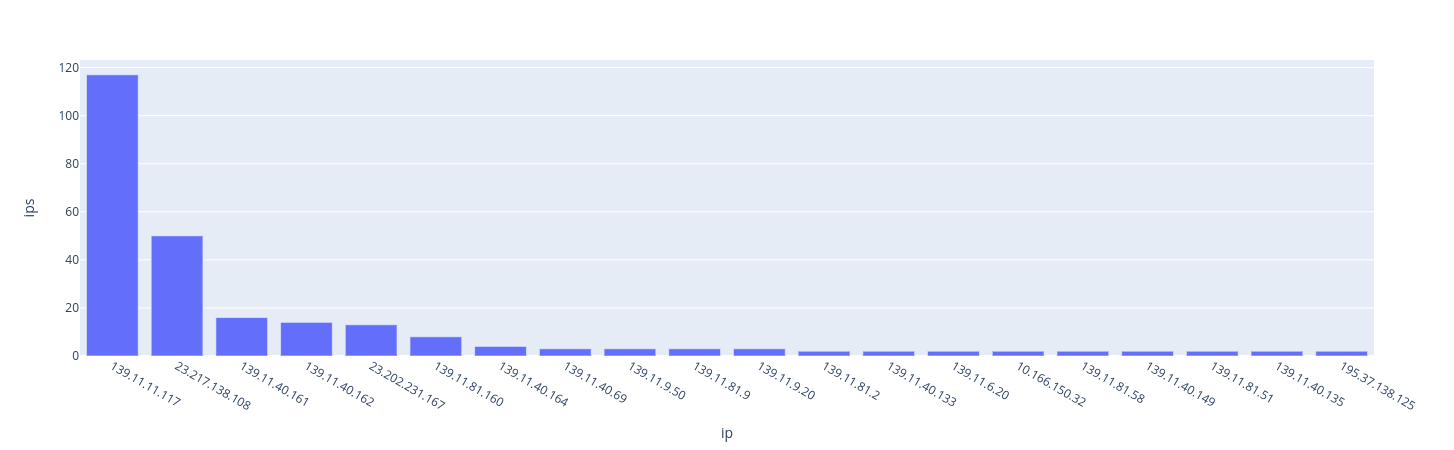

In [30]:
fig = px.bar(count_ip, x='ip', y='ips')
fig.show()

## Graph Visualisierung Subdomain und IPs

  * Darstellung als Graph mit Neo4j der Abhängigkeit von Subdomains zu
    * IP-Adressen
    * Webservern
    * aufgelösten/nicht aufgelösten Domains
    

In [31]:
graph = Graph("http://172.17.0.1:7474/", password="start123")
graph.delete_all()

In [32]:
graph.delete_all()
ip_dict = {}
domain_dict = {}

for index, row in subdomain_df.iterrows():
    if row["webserver"] and row["resolved"]:
        node = Node("Webserver", 
                    name=row["domainname"],
                    description="Webserver",
                    color="lime")
        graph.create(node)
        domain_dict[row["domainname"]] = node
    elif row["resolved"]:
        node = Node("Generic Server", 
                    name=row["domainname"], 
                    description="Generic Server",
                    color="yellow")
        graph.create(node)
        domain_dict[row["domainname"]] = node
    else:
        node = Node("Unreachable Server", 
                    name=row["domainname"], 
                    description="Unreachable Server",
                    color="red")
        graph.create(node)
        domain_dict[row["domainname"]] = node
        
for ip in subdomain_df['ips'].unique():
    node = Node("IP", 
                name=ip, 
                description="IP Address",
                color="blue")
    graph.create(node)
    domain_dict[ip] = node
        
for index, row in subdomain_df.iterrows():
    graph.create(Relationship(domain_dict[row["domainname"]], 
                              "belongs_to",
                              domain_dict[row["ips"]]))

In [33]:
output = draw(graph, physics=True, physics_model="forcedAtlas2Based")
output[0][0]

In [34]:
display(HTML(f'<a href={output[0][1]}> Click to download graph</a>'))